# Classification (and Risk Score)

- Determine if a customer will default on their next credit card payment

Candidate: jianfei.zhang@live.ca

In [27]:
import sys
import numpy as np
import pandas as pd
import missingno as msno
import math
import seaborn as sns
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

sys.path.insert(0, "../name-package")
import jzspine
plt.style.use('../name-package/jz-dark.mplstyle')
mpl.rcParams['figure.dpi']=300
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [4]:
def check_missing_values(d_train, d_test):
    fig, ax = plt.subplots(1, 2,  figsize=(30, 4))
    msno.matrix(d_train, ax=ax[0], sparkline=False)
    msno.matrix(d_test, ax=ax[1], sparkline=False)
    plt.show()
    
def impute_missing_values(d_train, d_test):
    d = d_train.append(d_test)
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    d[var_numerical] = imputer.fit_transform(d[var_numerical],1)
    # get training and test data back
    d_train, d_test = d.iloc[:d_train.shape[0]], d.iloc[d_train.shape[0]:]
    fig, ax = plt.subplots(1, 2,  figsize=(30, 4))
    msno.matrix(d_train, ax=ax[0], sparkline=False)
    msno.matrix(d_test, ax=ax[1], sparkline=False)
    plt.show()
    return d_train, d_test

def display_numerical(d_train):
    fig, axes = plt.subplots(2, 11,  figsize=(30, 8))
    plt.subplots_adjust(wspace=.2, hspace=.3)
    for i in range(22):
        x = d_train[var_numerical[i]].values
        row = int(np.floor(i/11)+1)
        col = int(i - (row-1)*11+1)
        axes[row-1,col-1].hist(x, bins=20, color=mpl.cm.Dark2.colors[1])
        axes[row-1,col-1].set_title('{}'.format(var_numerical[i]))
    plt.show()

def display_categorical(d_train):
    plt.figure(figsize=(10,3))
    x = d_train[var_categorical].values
    plt.bar(list(Counter(x).keys()), list(Counter(x).values()), color=mpl.cm.Dark2.colors[2])
    plt.title('{}'.format(var_categorical))
    plt.show()
    
def display_var_response(d_train):
    plt.figure(figsize=(10,3))
    x = d_train[var_response].values
    plt.bar(list(Counter(x).keys()), list(Counter(x).values()), color=mpl.cm.Dark2.colors[3])
    plt.title('{}'.format(var_response))
    plt.show()
    

def create_dummies(d_train, d_test):
    d = d_train.append(d_test)
    df = pd.get_dummies(d.MARRIAGE)
    df = df.drop('0',1)
    df = df.rename(columns={'1': 'married', '2': 'single', '3': 'divorced'})
    d = pd.concat([df,d],1)
    var = var_numerical + list(df)
    d_train, d_test = d.iloc[:d_train.shape[0]], d.iloc[d_train.shape[0]:]
    return d_train, d_test, var

def display_var_response_correlation(d_train, var):
    plt.figure(figsize=(7,7))
    matrix = np.triu(df_train[var].corr())
    sns.heatmap(df_train[var].corr(), xticklabels=df_train[var].columns, yticklabels=df_train[var].columns, mask=matrix, cmap="Greens")
    plt.title('Correlation')
    plt.show()

In [56]:
# load training and test data

var_categorical = 'MARRIAGE'
var_response = 'default.payment.next.month'

d_train, d_test = pd.read_csv("./Train/classification_train.csv", dtype={var_categorical: object, var_response: object}).replace('NA', np.nan), pd.read_csv("./Test/classification_test.csv", dtype={var_categorical: object, var_response: object}).replace('NA',np.nan)

# define numerical and categorical variables
var_numerical = d_train.columns.values.tolist()
var_numerical.remove(var_categorical)
var_numerical.remove(var_response)
var_numerical.remove('ID')

In [57]:
d_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,17290,170000,2,3,1,40,1,2,0,0,...,19520,5200,0,0,2000,1136,1000,0,36679,1
1,16942,20000,1,3,3,59,2,0,0,0,...,18055,18755,20299,1596,1600,1300,1000,2000,0,1
2,2220,340000,2,1,1,41,-1,2,-1,-1,...,3570,3094,14645,0,24386,3570,0,14645,4534,1
3,13615,70000,2,3,3,39,0,0,-1,0,...,15133,3148,4699,3000,11000,5000,3150,2000,4000,0
4,11197,120000,2,2,2,28,-1,-1,-1,-1,...,390,390,14613,3821,1113,390,390,14613,770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,16108,280000,2,2,1,42,2,0,0,0,...,135264,133046,126155,5000,10000,5000,5000,5000,5000,1
23996,21327,50000,1,3,2,52,0,0,0,0,...,0,0,0,1357,1000,0,0,0,0,1
23997,3169,20000,1,2,2,33,-1,0,0,0,...,19983,20066,19855,1272,19288,681,917,1000,889,0
23998,22588,80000,2,3,3,48,0,0,0,0,...,4456,33661,34275,2030,2000,2000,30000,12000,0,0


In [58]:
d_test

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,15,250000,1,1,2,29,0,0,0,0,...,59696,56875,55512,3000,3000,3000,3000,3000,3000,0
1,17,20000,1,1,2,24,0,0,2,2,...,18338,17905,19104,3200,0,1500,0,1650,0,1
2,18,320000,1,1,1,49,0,0,0,-1,...,70074,5856,195599,10358,10000,75940,20000,195599,50000,0
3,30,50000,1,1,2,26,0,0,0,0,...,17907,18375,11400,1500,1500,1000,1000,1600,0,0
4,33,100000,1,1,2,32,0,0,0,0,...,80958,78703,75589,3023,3511,3302,3204,3200,2504,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,29986,240000,1,1,2,30,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
5996,29990,150000,1,1,2,35,-1,-1,-1,-1,...,780,0,0,9054,0,783,0,0,0,0
5997,29991,140000,1,2,1,41,0,0,0,0,...,138262,49675,46121,6000,7000,4228,1505,2000,2000,0
5998,29992,210000,1,2,1,34,3,2,2,2,...,2500,2500,2500,0,0,0,0,0,0,1


## Check missing values 

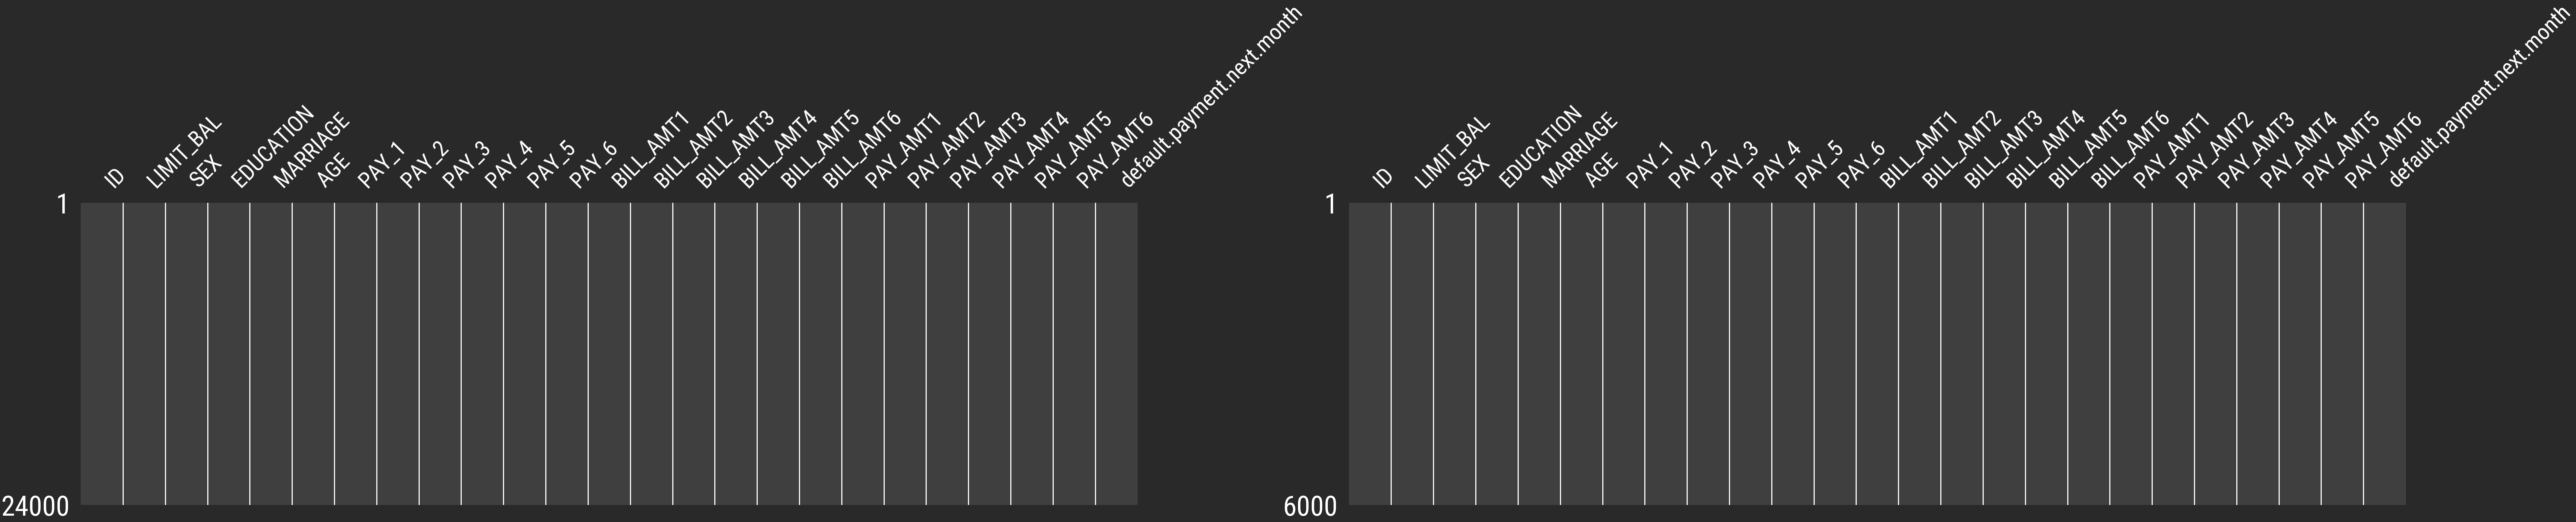

In [59]:
# missing values in training data (left) and in test data (right); no missing values !!
check_missing_values(d_train, d_test)

## Visual Exploration

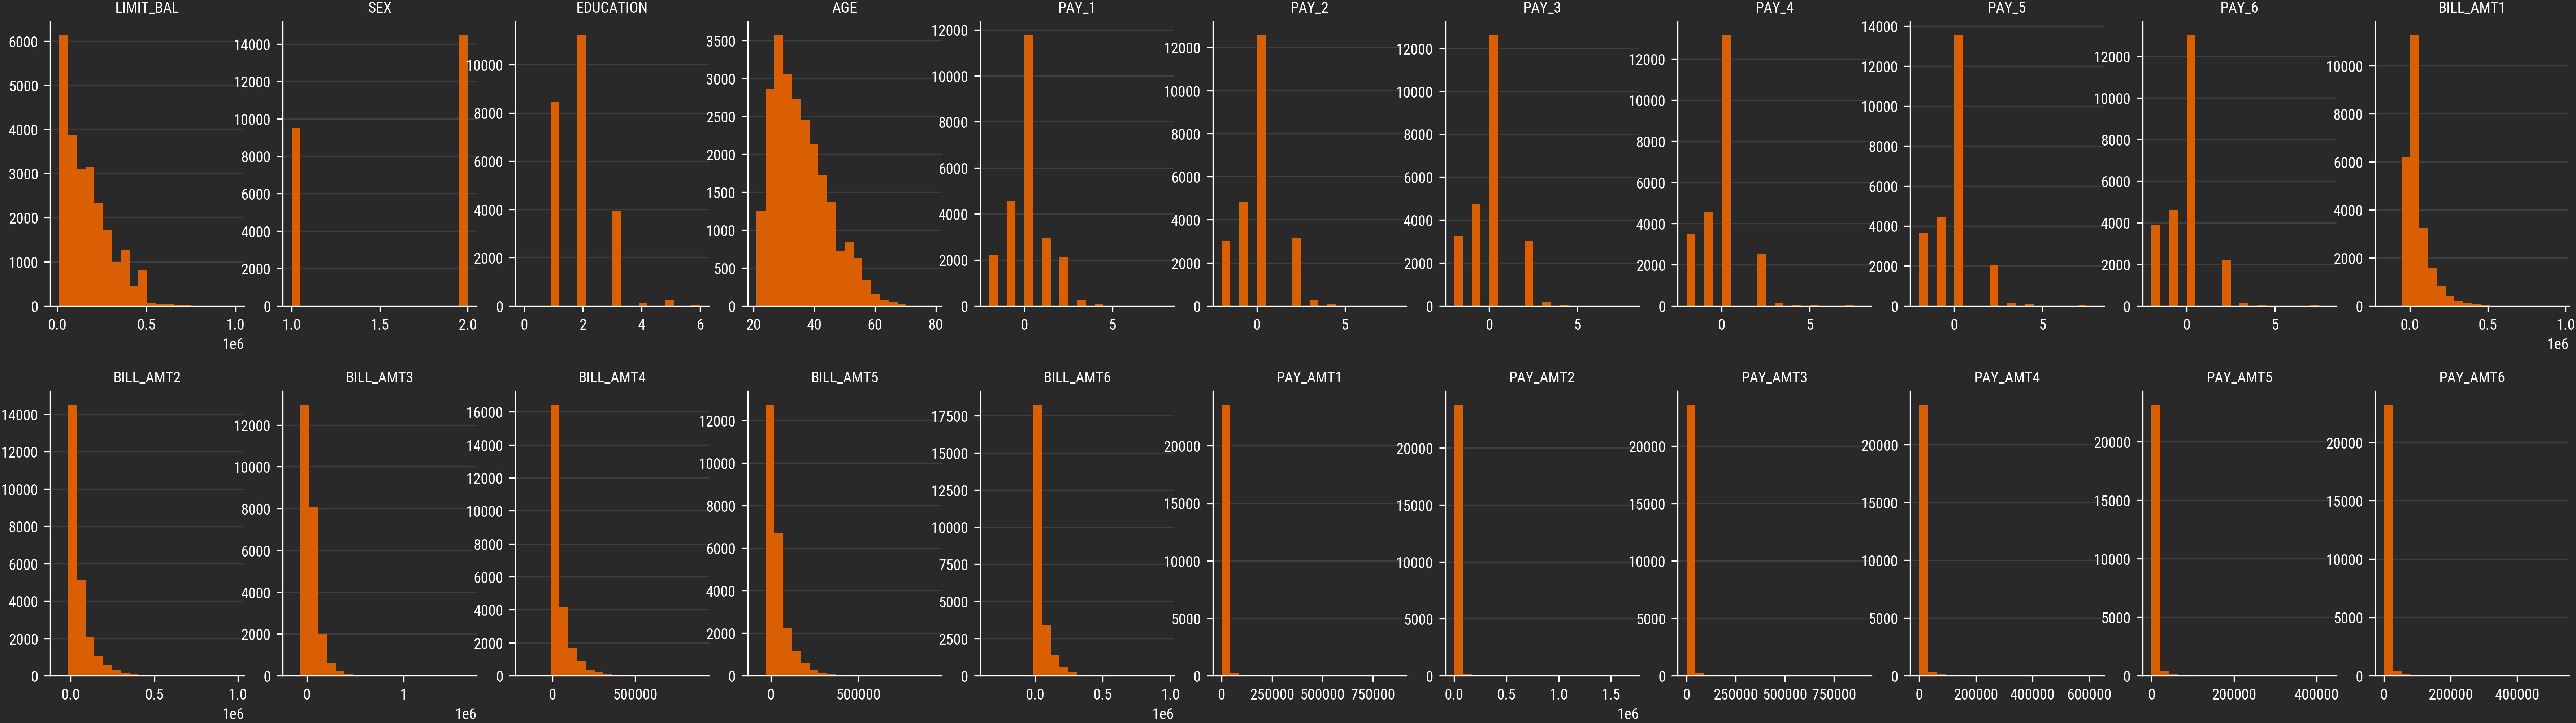

In [60]:
# - The numerial variables have very few outliers and seem to follow normal distributions; 
# - here binary SEX, ordinary EDUCATION are considered as numerical
display_numerical(d_train)

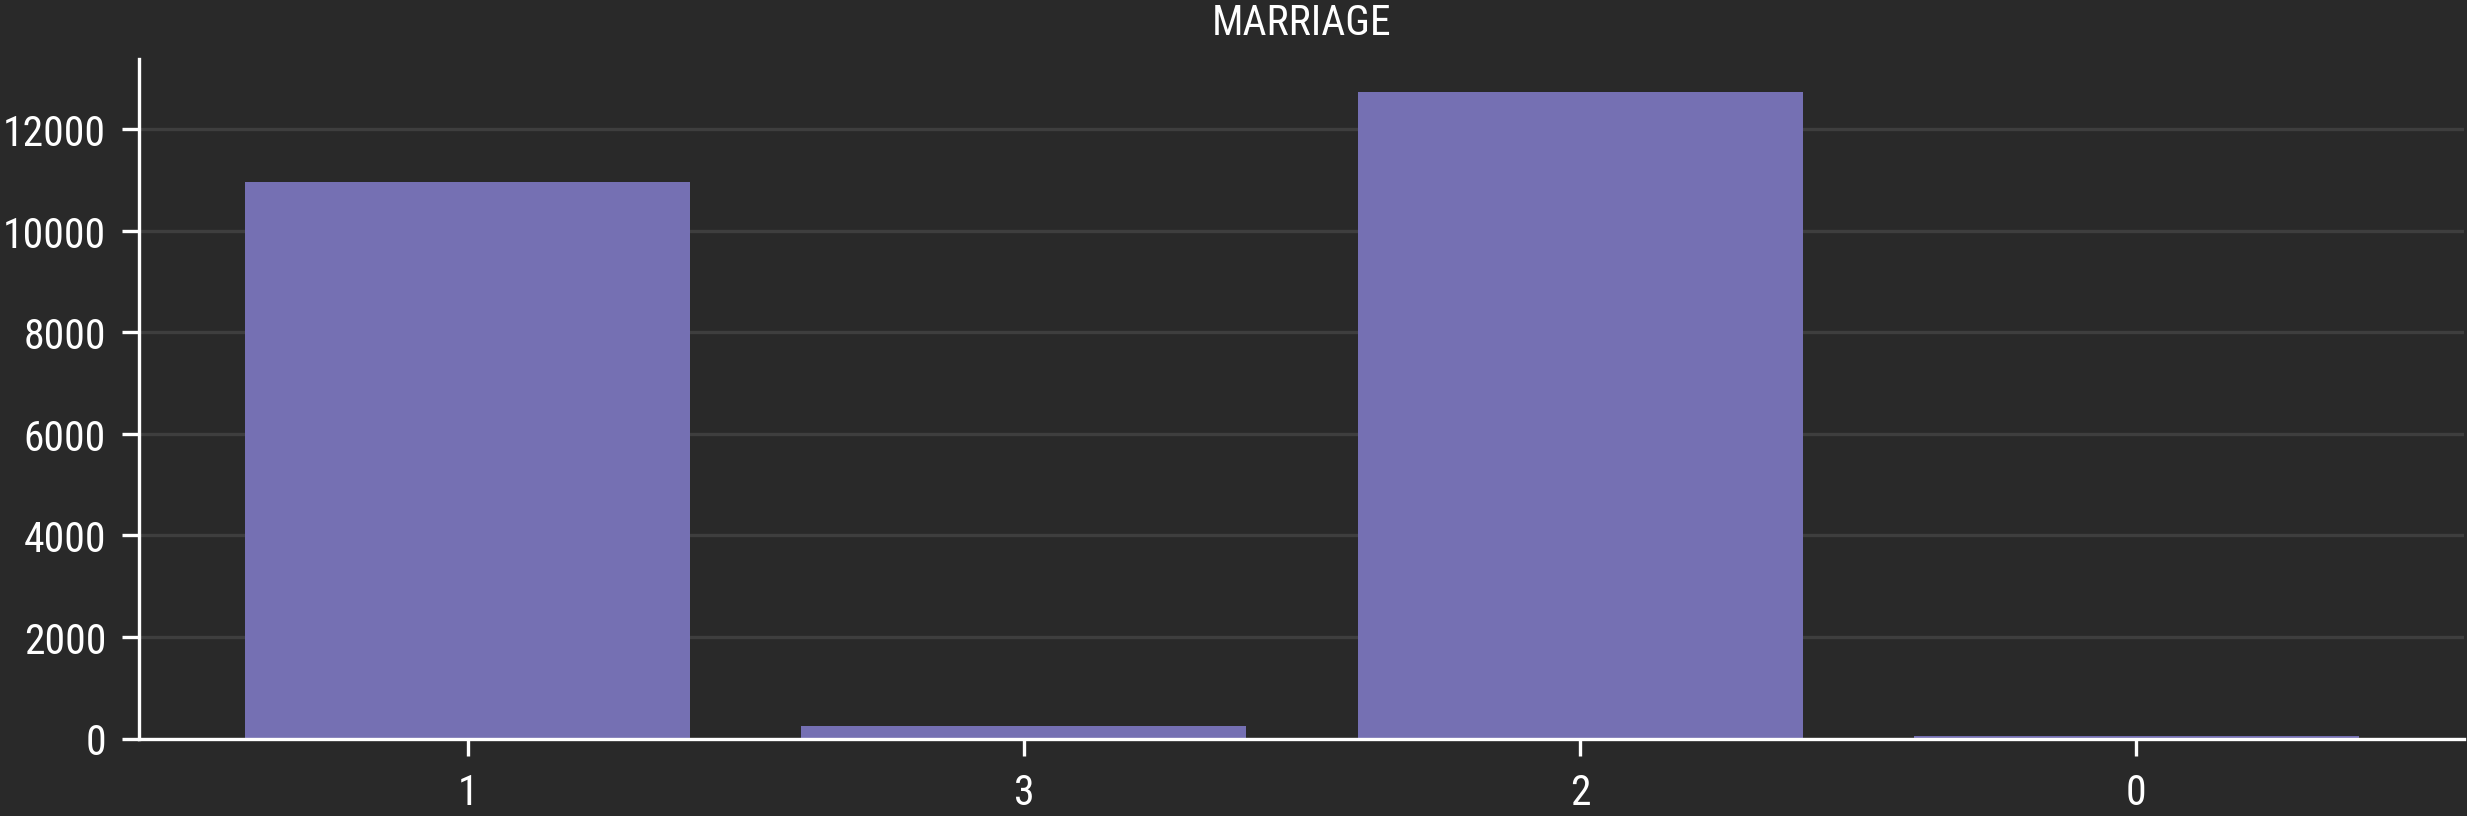

In [61]:
# The categorical variable (MARRIAGE) follows uniform distribution
display_categorical(d_train)

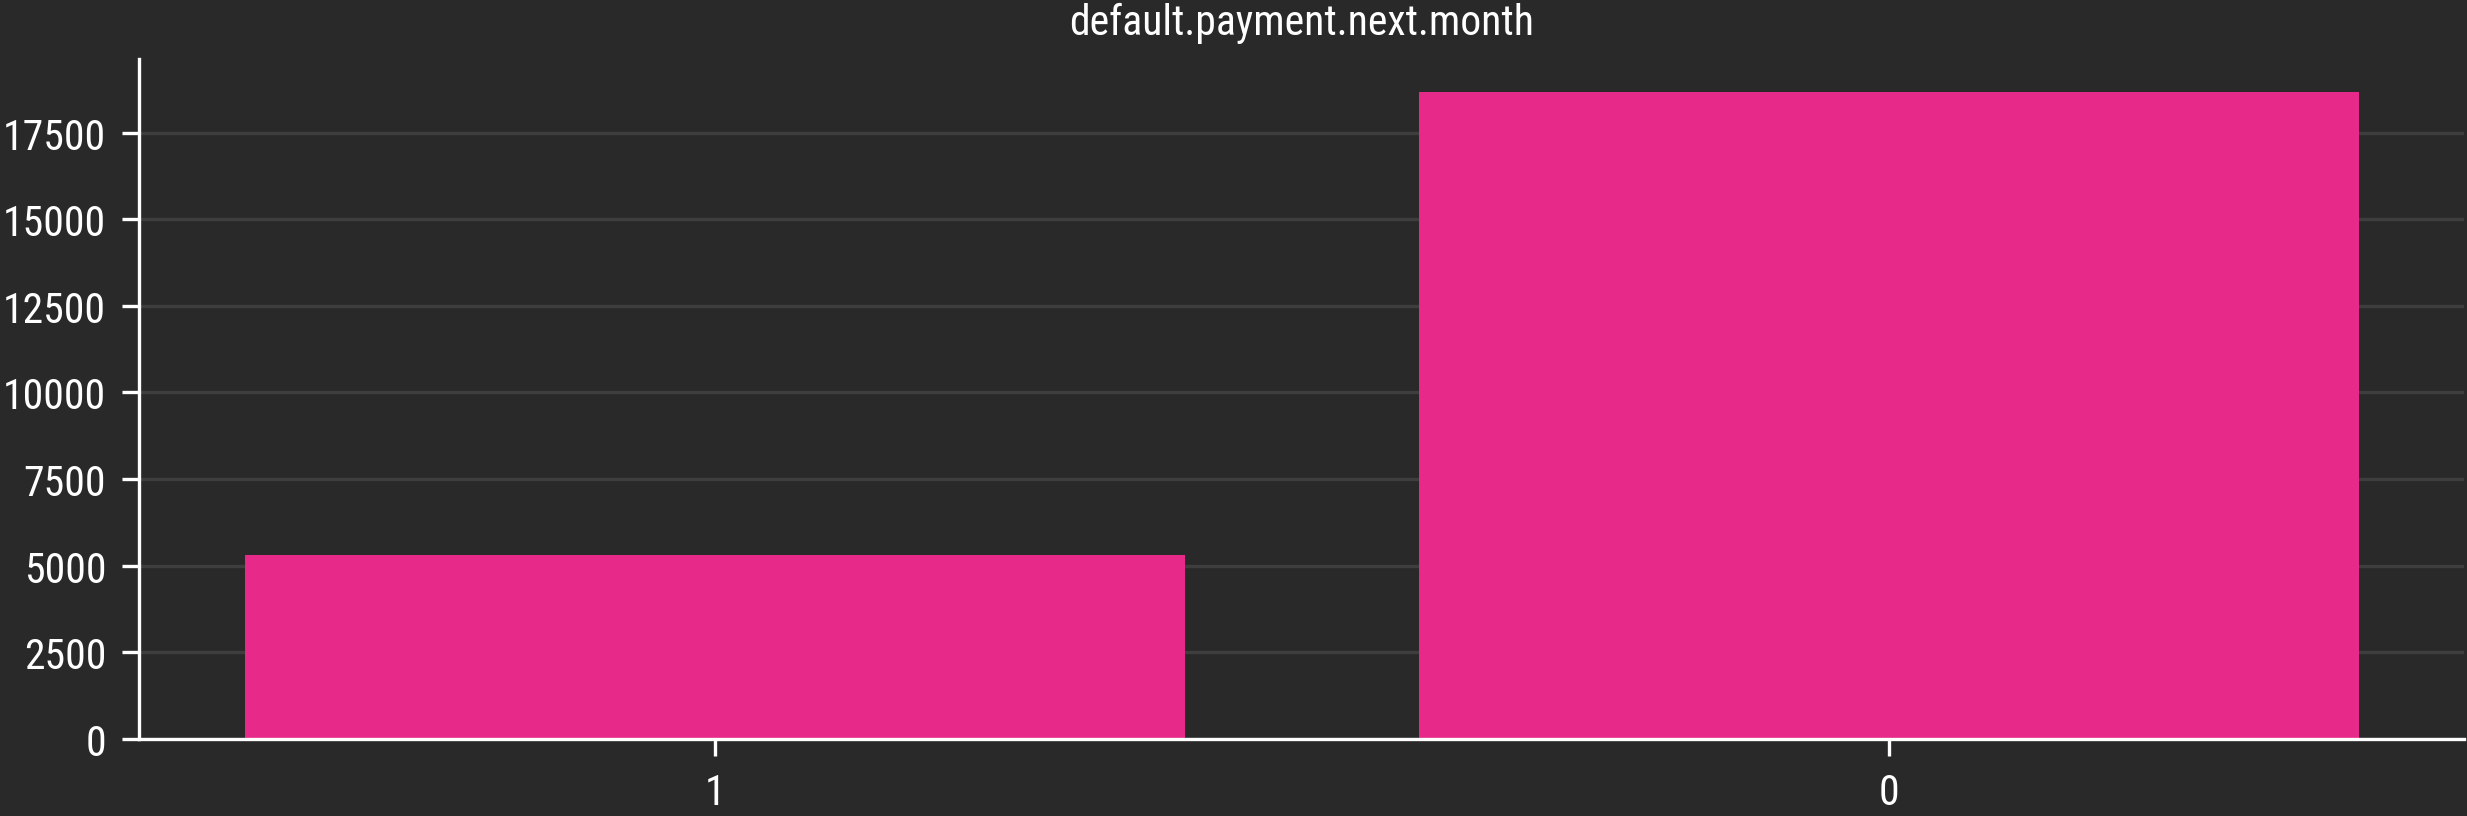

In [62]:
# The two classes (targets) are not balance
display_var_response(d_train)

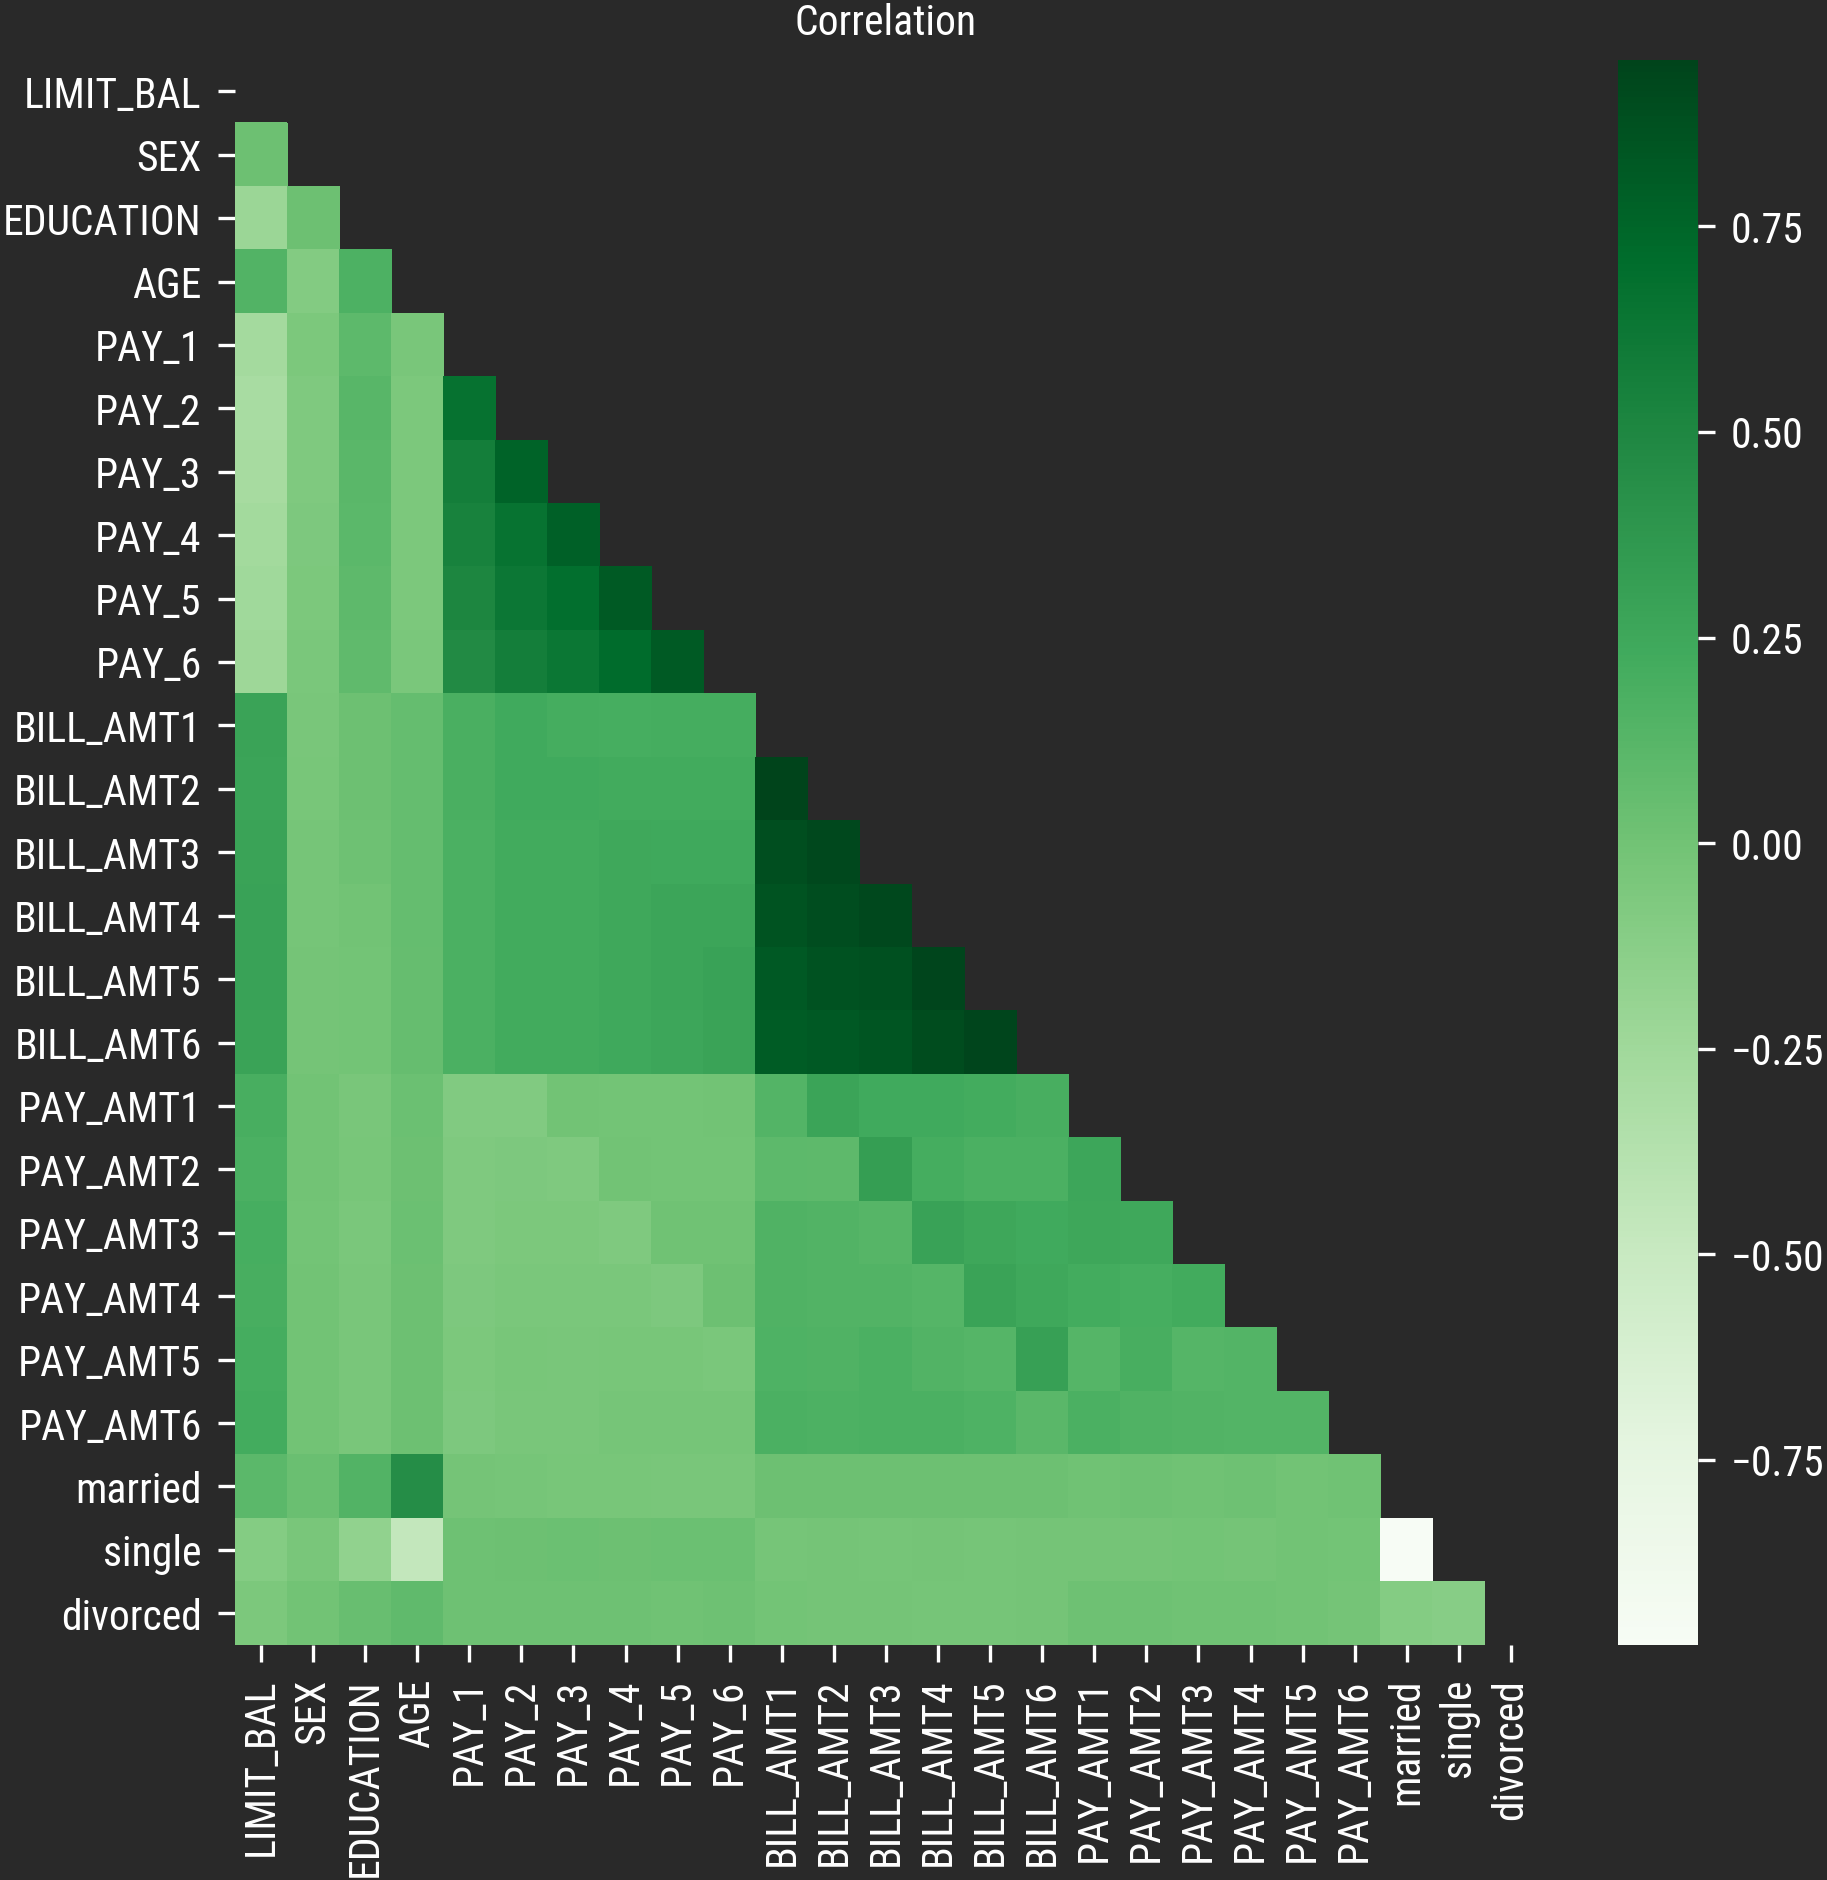

In [63]:
# The correlation between variables, no alert !
df_train, df_test, var = create_dummies(d_train, d_test)
display_var_response_correlation(df_train, var)

## Modeling and Prediction

- Three classifiers: Logistic, Decision Tree, and Random Forest

- Two metrics: Accuracy and F1-score

In [55]:
# input x and output y
x_train, y_train = df_train[var], df_train[var_response]
x_test, y_test = df_test[var], df_test[var_response]


In [12]:
names = [
    "Logistic",
    "Decision Tree", 
    "Random Forest", 
]

classifiers = [
    LogisticRegression(solver='liblinear', max_iter=1000),
    DecisionTreeClassifier(max_depth=4),
    RandomForestClassifier(n_estimators=100, max_depth=20, max_features=3)
]


IM = []
Accuracy = []
F1 = []
Risk = []
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train.values.ravel())  
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)
    #average_precision = average_precision_score(y_test, y_pred_prob[:,1], pos_label="0")
    #precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1], pos_label="0")
    #auc_precision_recall = auc(recall, precision)
    Risk.append(y_pred_prob)
    if name is 'Logistic':
        importance = clf.coef_[0]
    else: importance = clf.feature_importances_
    IM.append(importance)
    Accuracy.append(accuracy_score(y_test, y_pred))
    F1.append(f1_score(y_test, y_pred, pos_label='0'))

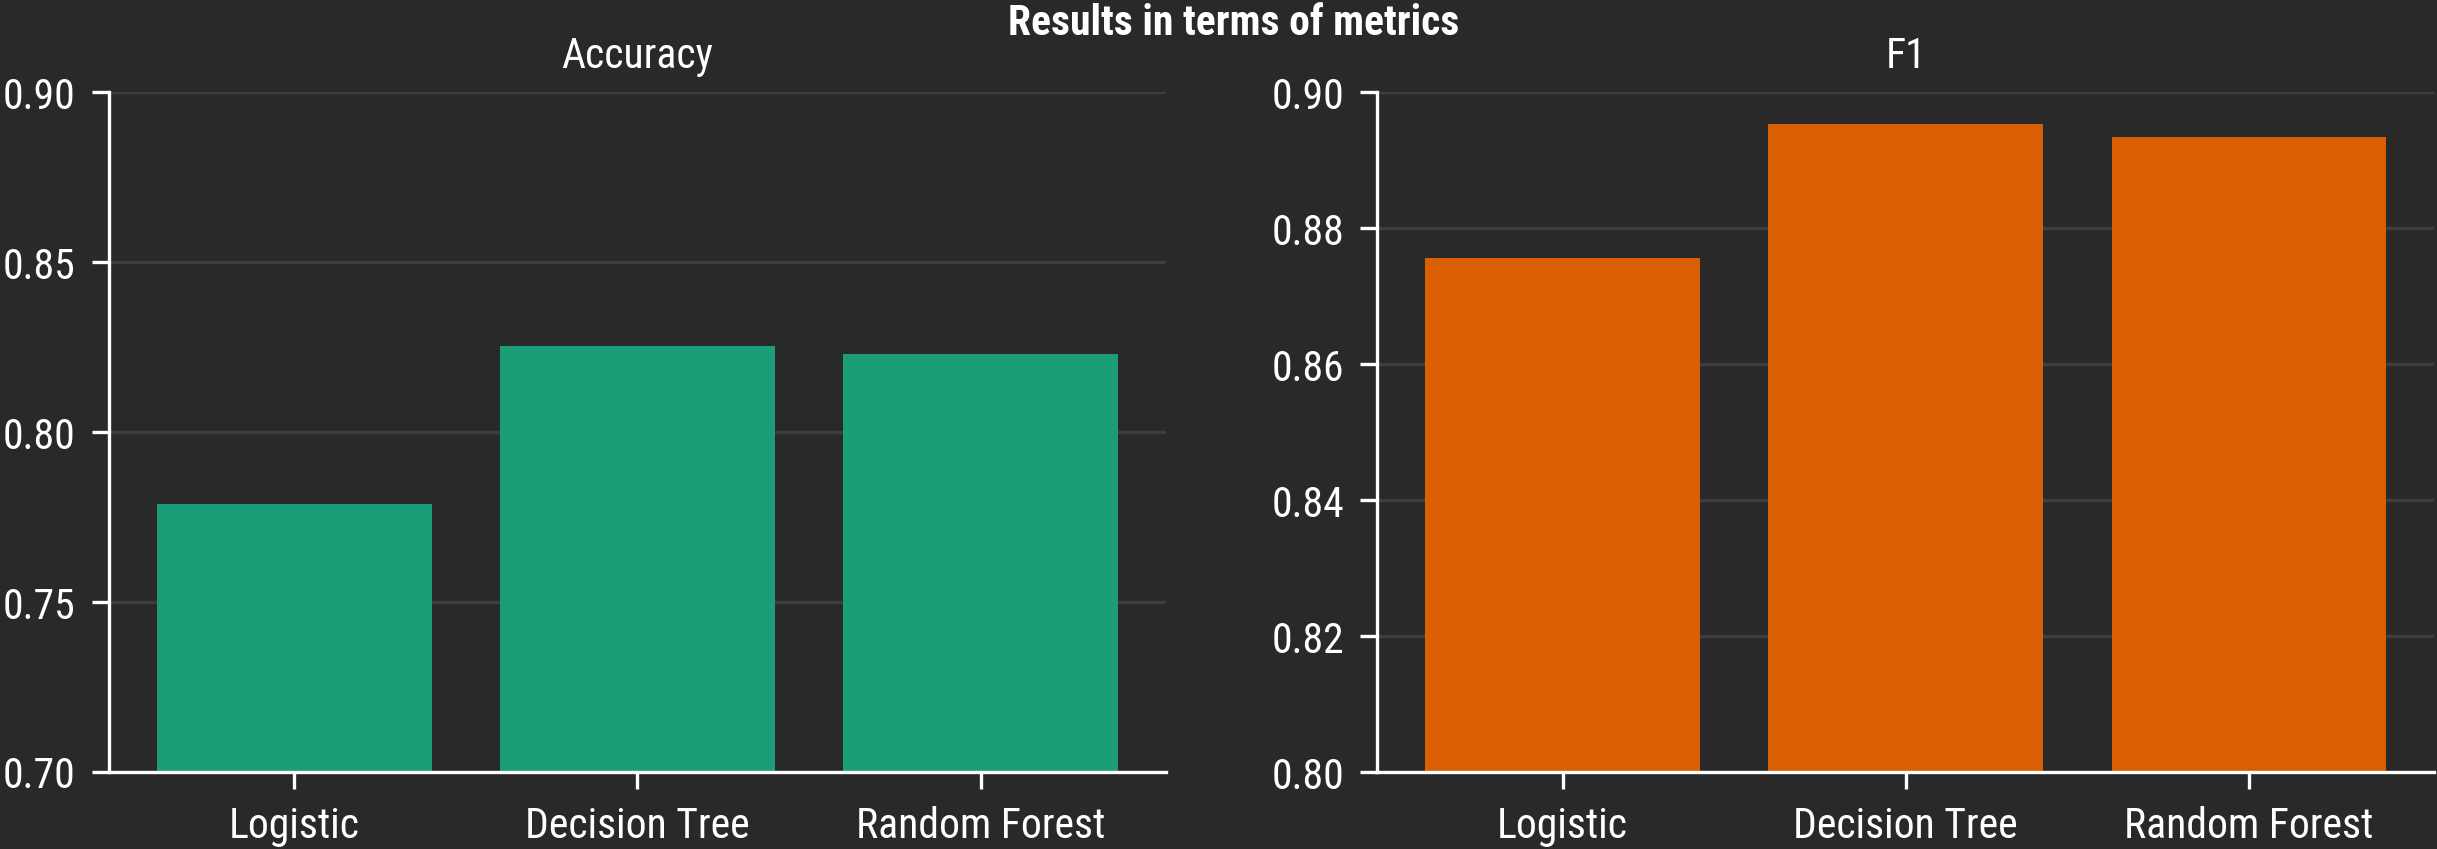

In [13]:
# Display 
fig, ax = plt.subplots(1, 2,  figsize=(10,3))
for i in range(2):
    #for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    ax[i].bar(names, [Accuracy, F1][i], color=mpl.cm.Dark2.colors[i])
    ax[i].set_ylim([0.7, 0.8][i],[0.90, 0.90][i])
    ax[i].set_title(['Accuracy', 'F1'][i])
    #ax[i].set_xticklabels(var, rotation=90, ha='right')
plt.suptitle('Results in terms of metrics', fontweight='bold')
fig.savefig('results.png', bbox_inches = 'tight')
plt.show()

In [14]:
# Random Forest' performance
display(round(Accuracy[2],3),round(F1[2],3))

0.823

0.893

### Interpret the importance of each variables in decision (i.e., predctions made by models)

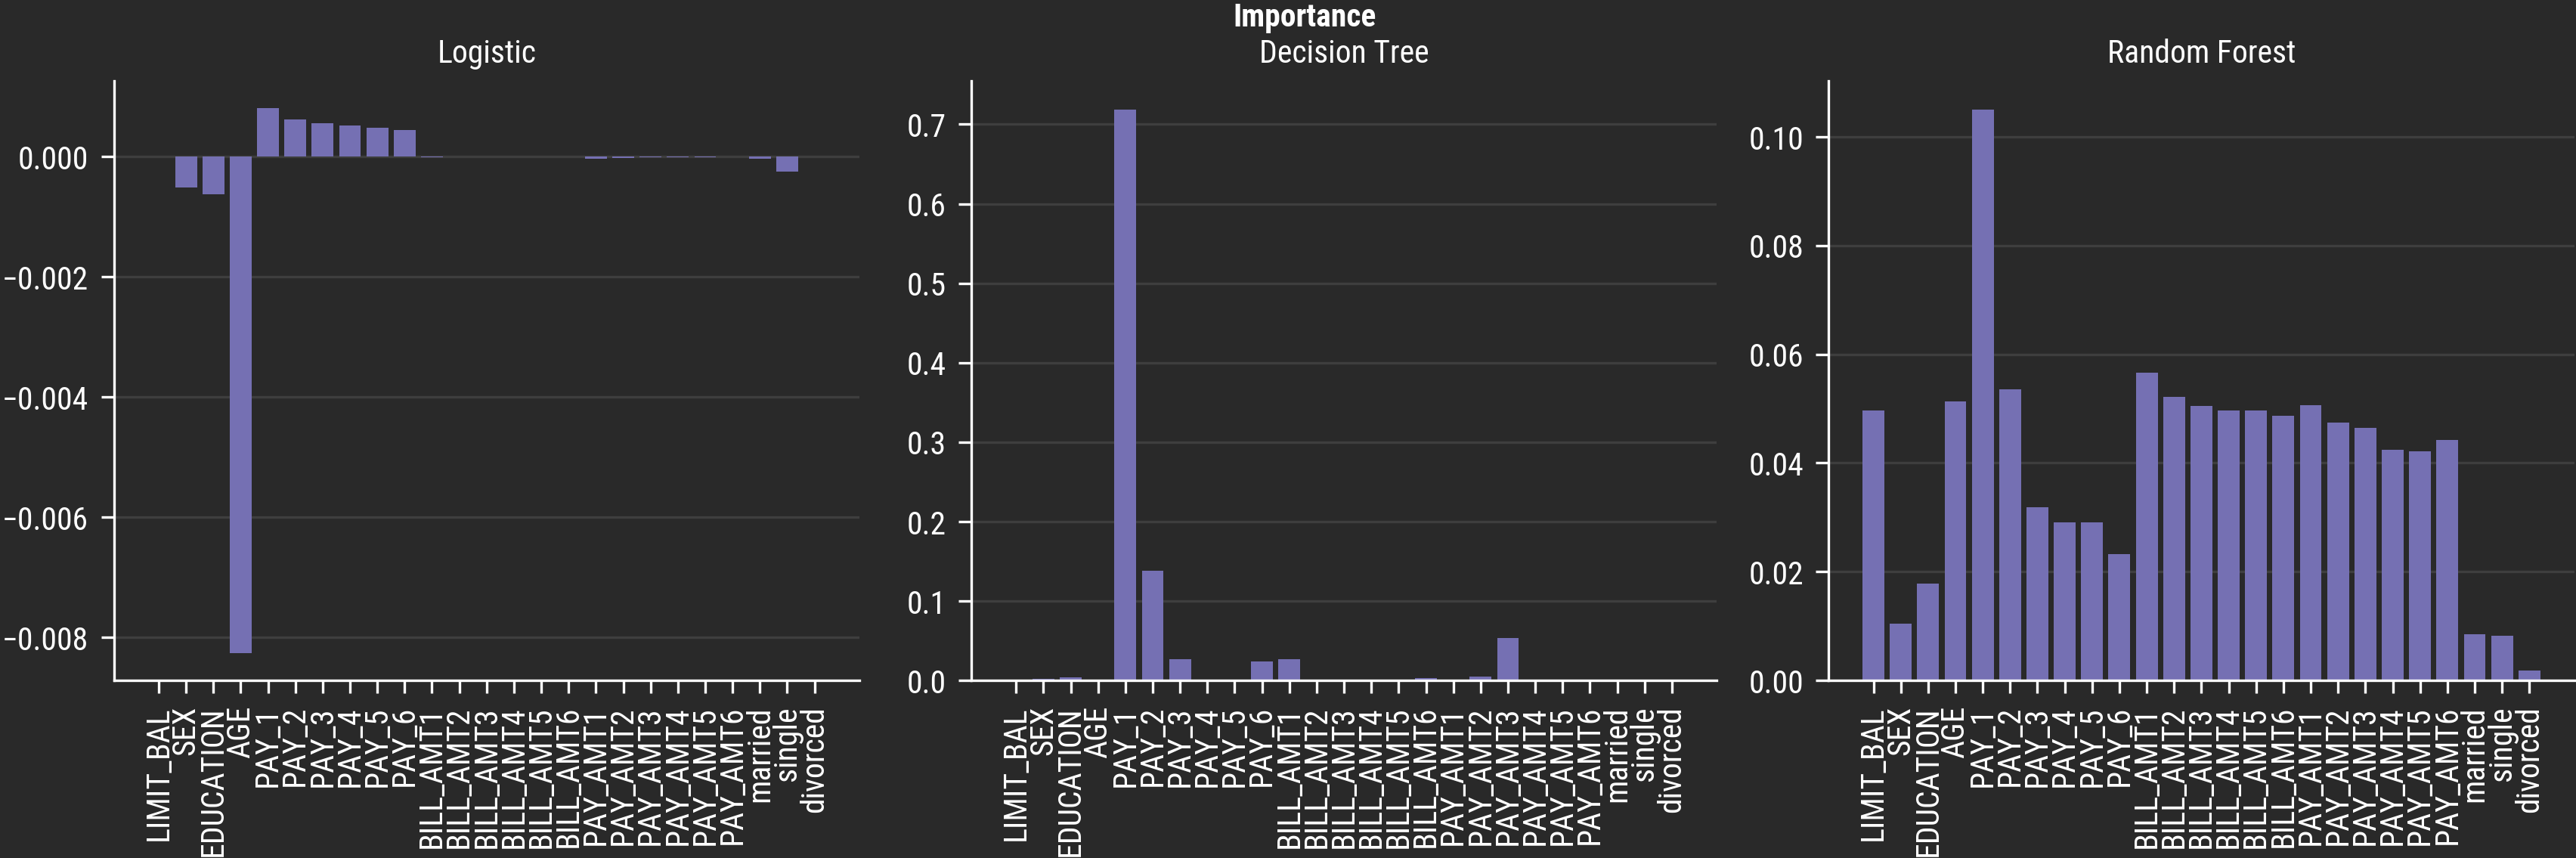

In [15]:
fig, ax = plt.subplots(1, 3,  figsize=(14, 3.5))
plt.subplots_adjust(wspace=.15, hspace=.3)
for i in range(len(IM)):
    plt.subplot(1,3,i+1)
    plt.bar(var, IM[i], color=mpl.cm.Dark2.colors[2])
    plt.xticks(var, rotation = 90, ha = 'center')
    plt.title(names[i])
plt.suptitle('Importance', fontweight='bold')
fig.savefig('importance.png', bbox_inches = 'tight')
plt.show()

## Risk Score

- The risk score is the predicted probability of defaulted 

- No feature selection

- Random Forest: high vs. low risk score

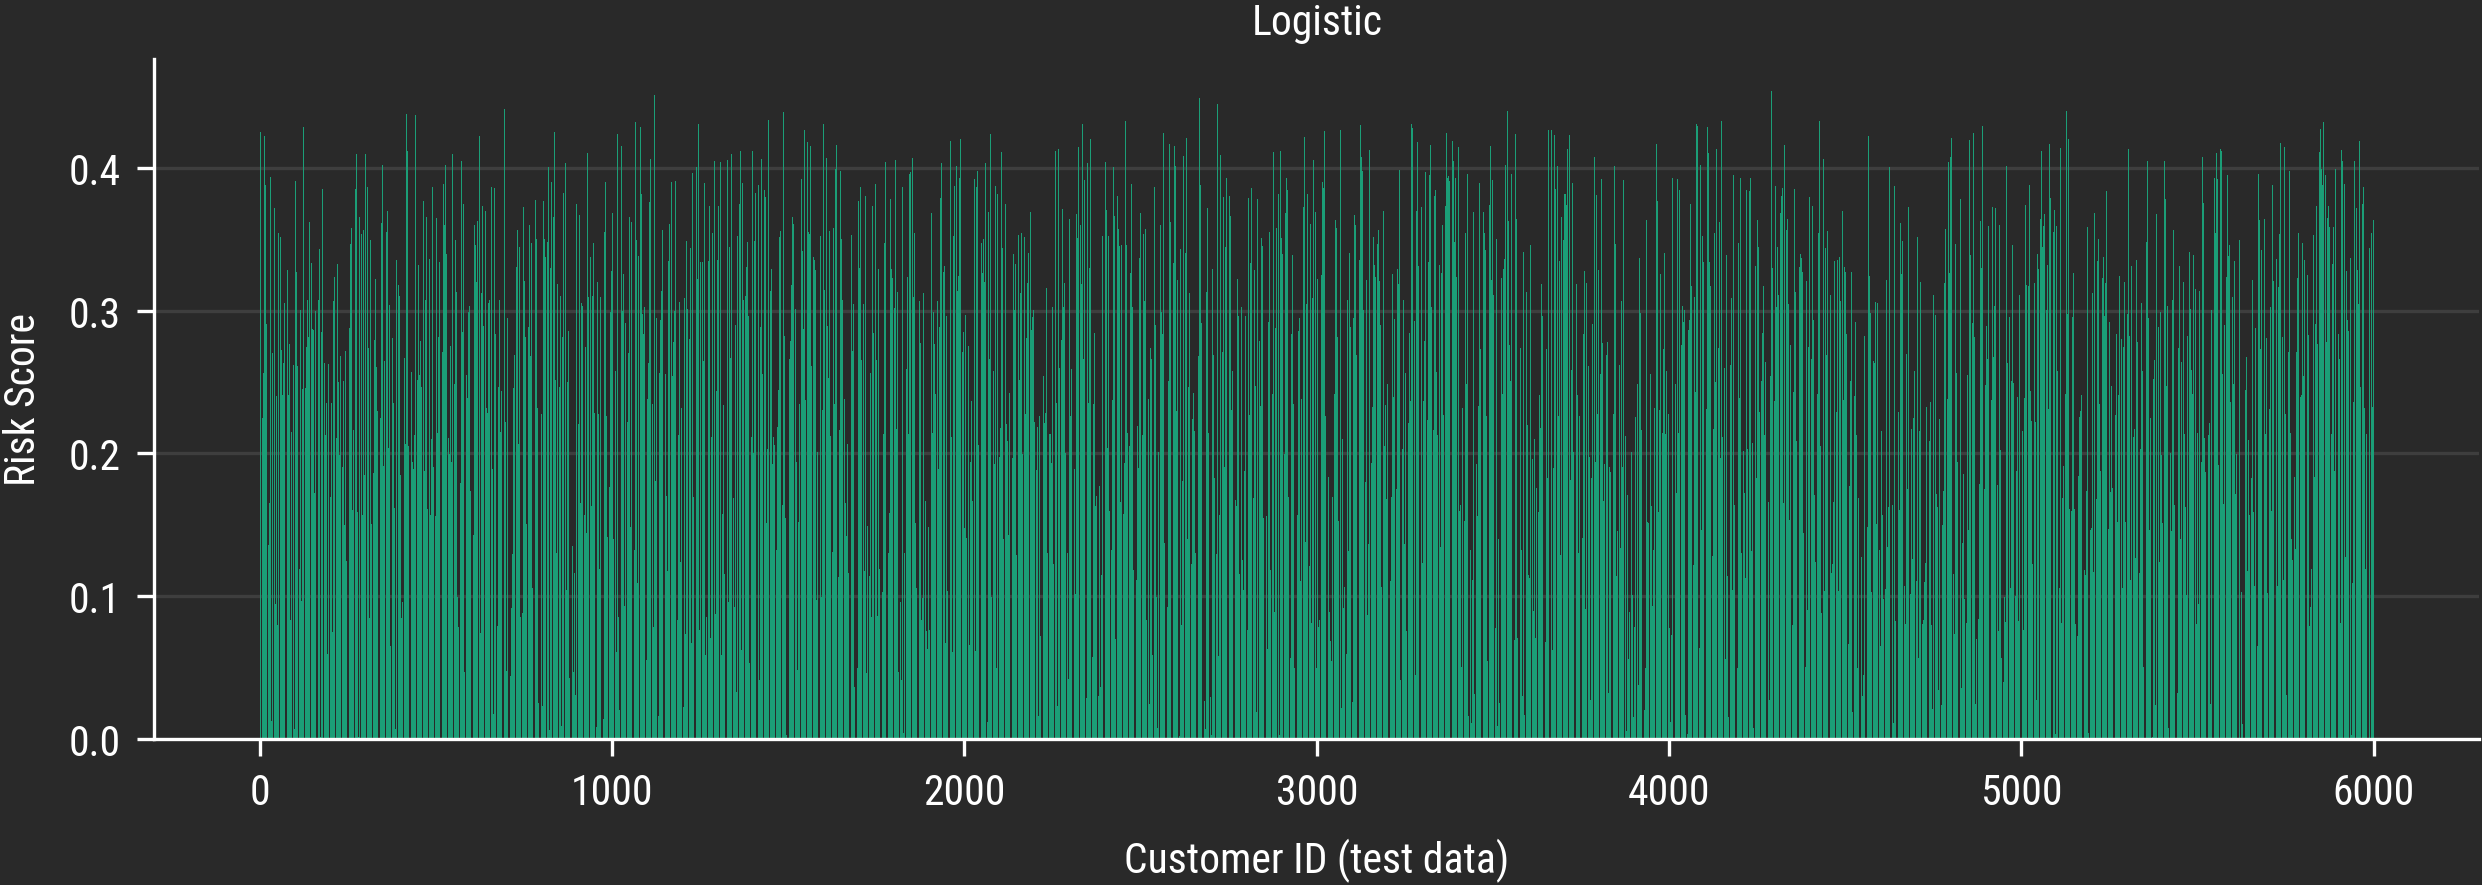

In [16]:
# Risk score by Logistic model

plt.figure(figsize=(10,3))
plt.bar(d_test.index+1,Risk[0][:,1], color=mpl.cm.Dark2.colors[0])
plt.title('Logistic')
plt.xlabel('Customer ID (test data)')
plt.ylabel('Risk Score')
plt.savefig('Logistic_Risk.png', bbox_inches = 'tight')
plt.show()

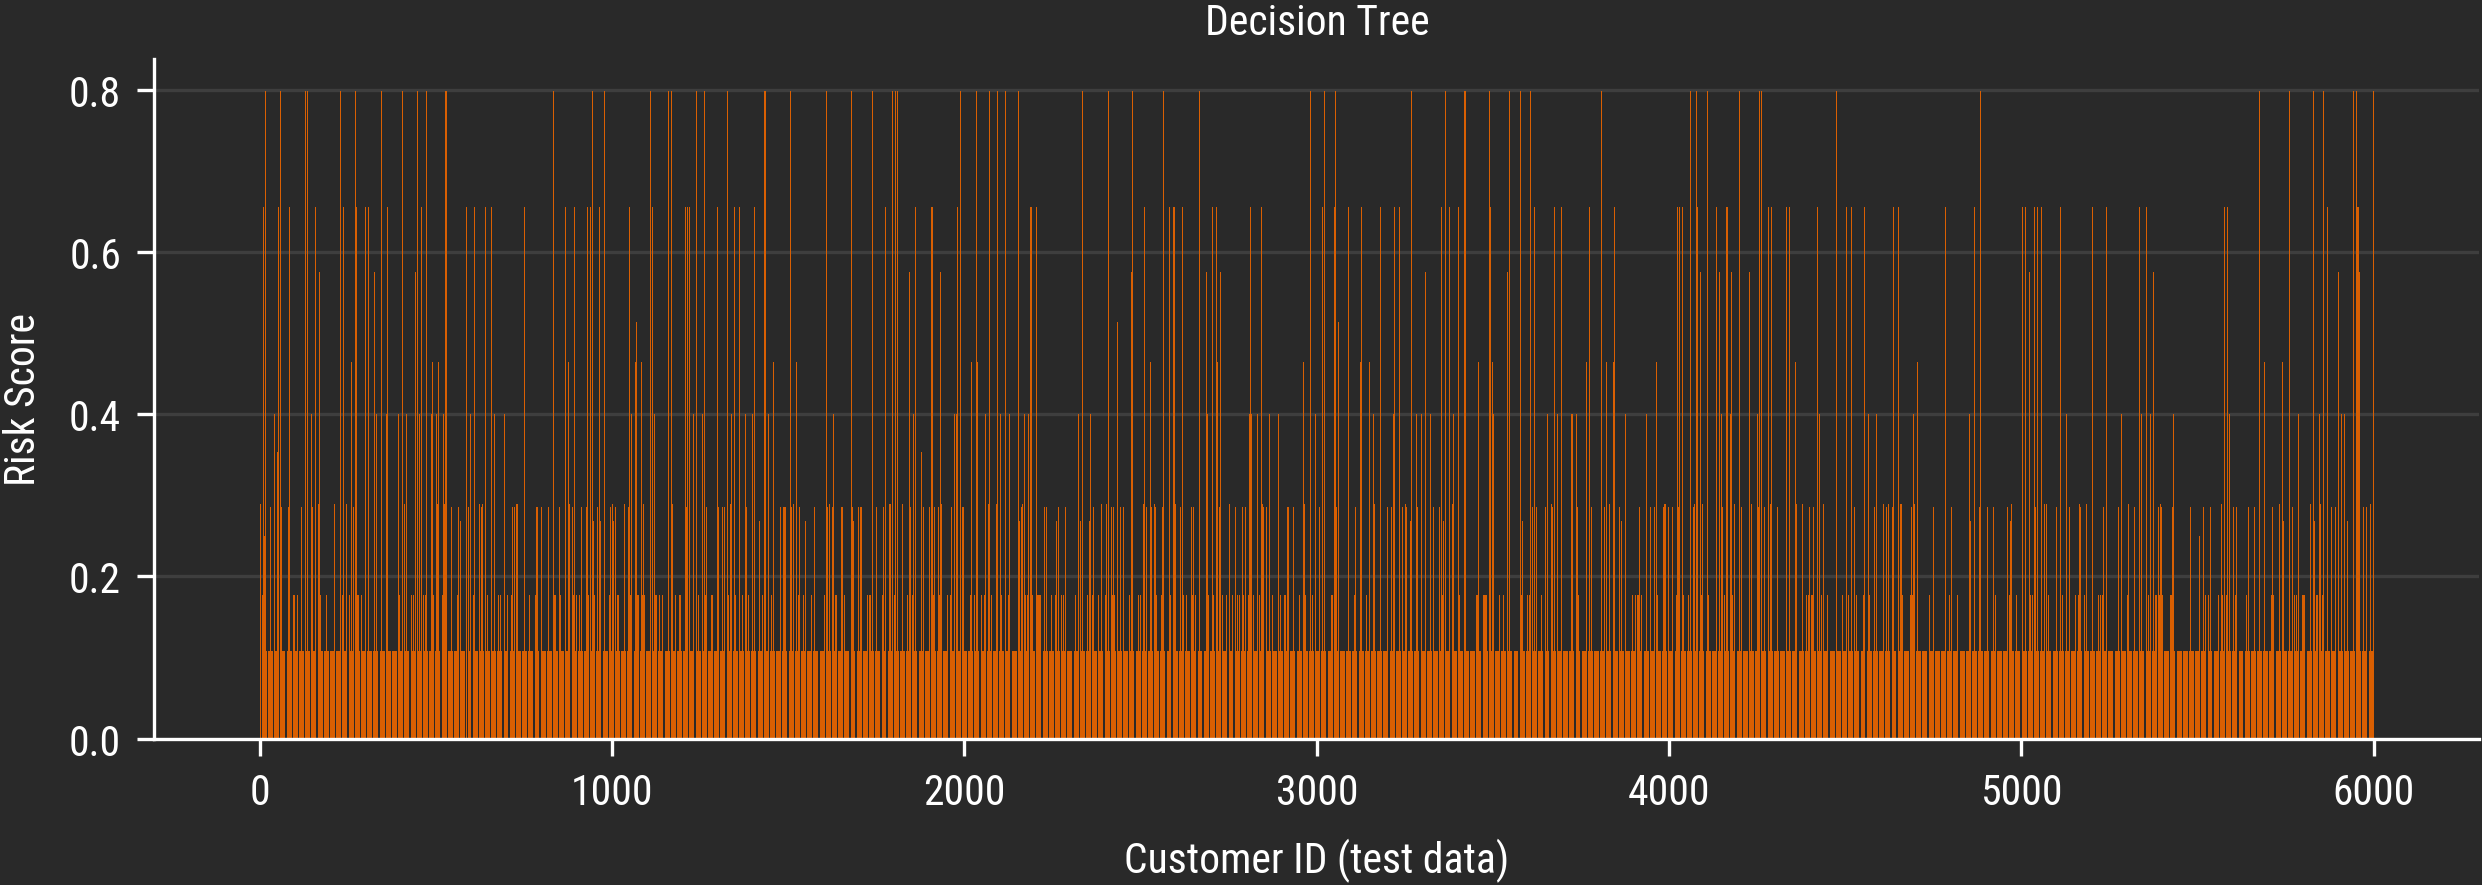

In [17]:
# Risk score by Decision Tree

plt.figure(figsize=(10,3))
plt.bar(d_test.index+1,Risk[1][:,1], color=mpl.cm.Dark2.colors[1])
plt.title('Decision Tree')
plt.xlabel('Customer ID (test data)')
plt.ylabel('Risk Score')
plt.savefig('DecisionTree_Risk.png', bbox_inches = 'tight')
plt.show()

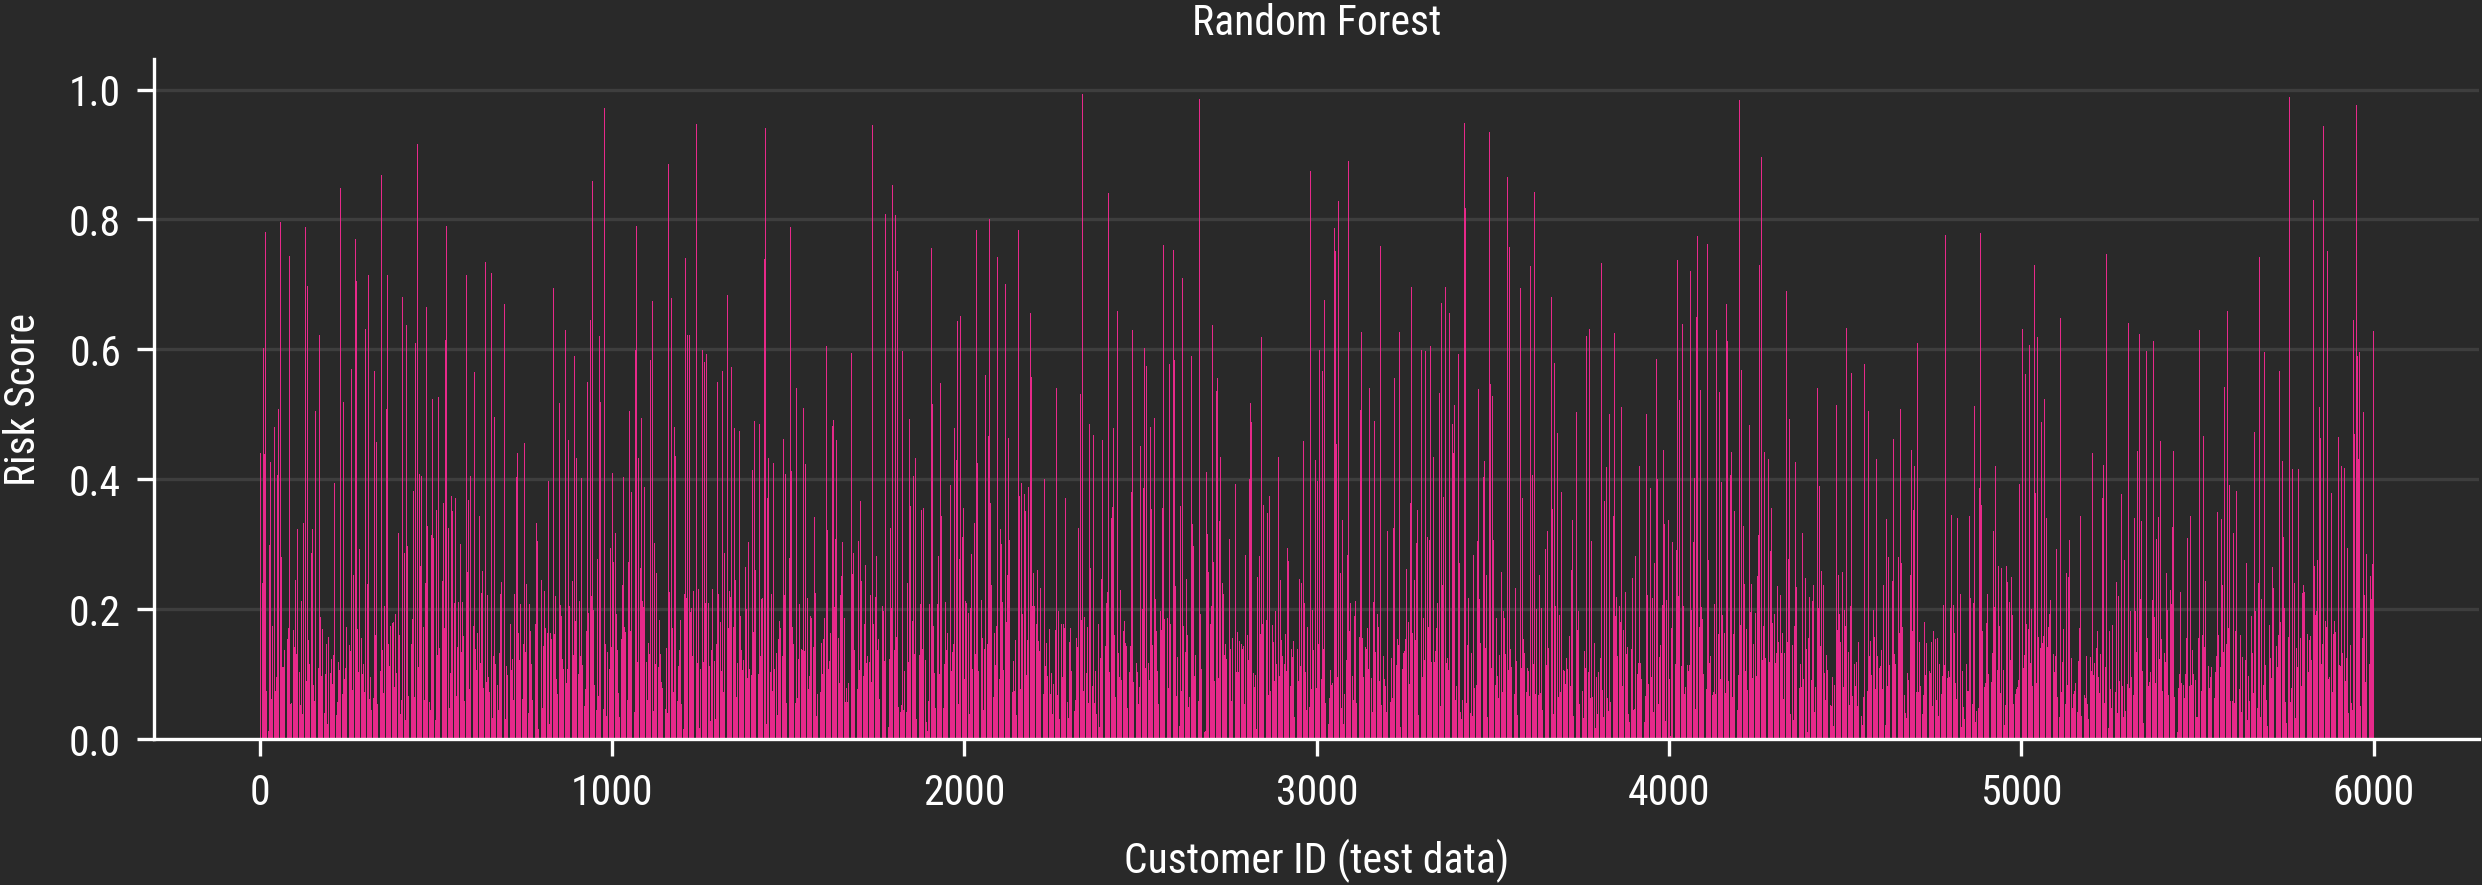

In [18]:
# Risk score by Random Forest

plt.figure(figsize=(10,3))
plt.bar(d_test.index+1,Risk[2][:,1], color=mpl.cm.Dark2.colors[3])
plt.title('Random Forest')
plt.xlabel('Customer ID (test data)')
plt.ylabel('Risk Score')
plt.savefig('RandomForest_Risk.png', bbox_inches = 'tight')
plt.show()

### Featurer Selection for Prediction

- Pipeline: Feature selection + Random Forest model

- maintain the high accruacy and F1-score

- high and low risk scores are easily distinguished (compared to its original performance) !!!

In [19]:
# Feature selection + Random Forest

names = [
    "Random Forest", 
]

classifiers = [
    Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(mutual_info_classif, k=5)), ('RF', RandomForestClassifier(n_estimators=100, max_depth=20, max_features=3))])
]

Accuracy = []
F1 = []
Risk = []
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train.values.ravel())
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)
    Risk.append(y_pred_prob)
    Accuracy.append(accuracy_score(y_test, y_pred))
    F1.append(f1_score(y_test, y_pred, pos_label='0'))

In [20]:
# maintain the high accuray and F1-score

display(round(Accuracy[0],3),round(F1[0],3))

0.821

0.892

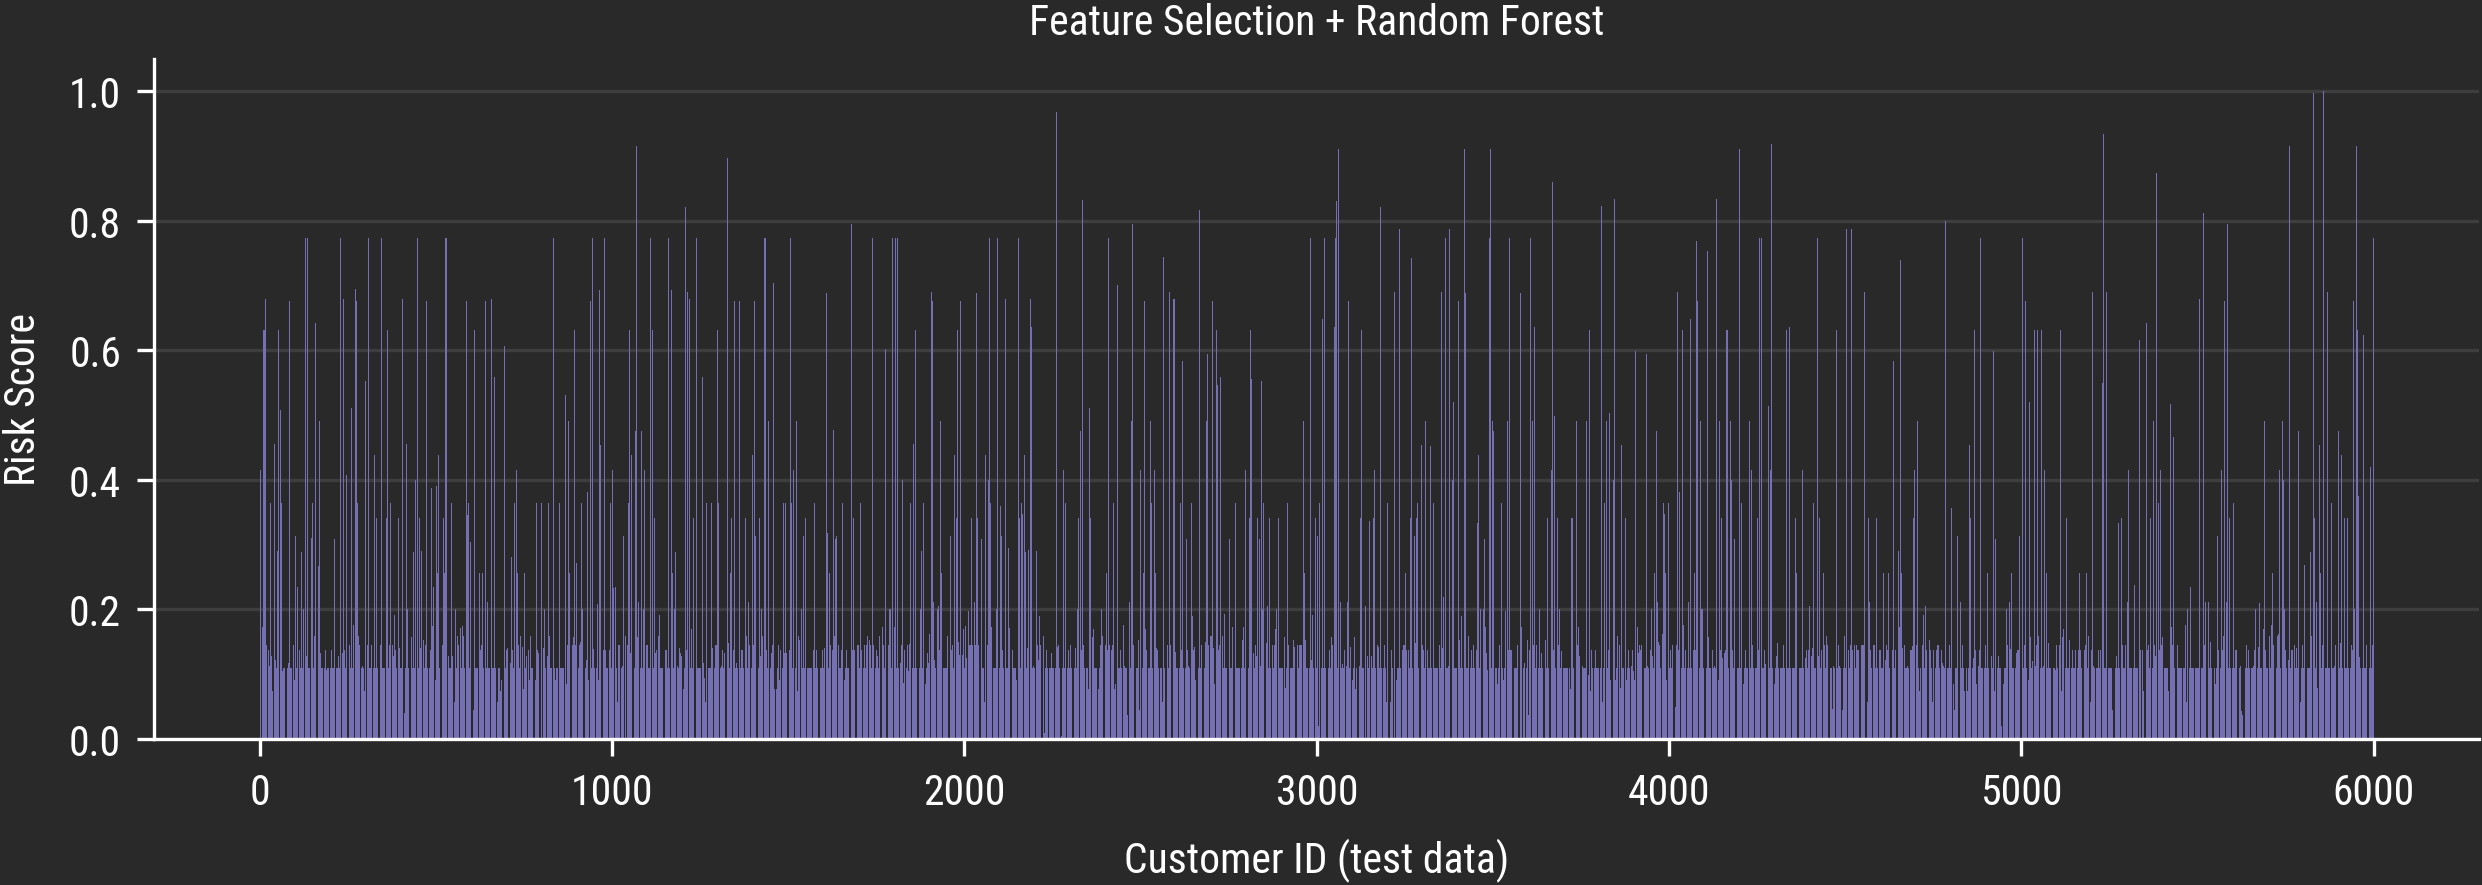

In [21]:
# Easy to distinguish risk scores

plt.figure(figsize=(10,3))
plt.bar(d_test.index+1,Risk[0][:,1], color=mpl.cm.Dark2.colors[2])
plt.title('Feature Selection + Random Forest')
plt.xlabel('Customer ID (test data)')
plt.ylabel('Risk Score')
plt.savefig('FS+RandomForest_Risk.png', bbox_inches = 'tight')
plt.show()